# Aprendizado Profundo - UFMG

## Preâmbulo

O código abaixo consiste dos imports comuns. Além do mais, configuramos as imagens para ficar de um tamanho aceitável e criamos algumas funções auxiliares. No geral, você pode ignorar a próxima célula.

In [ ]:
# !pip install mxnet-cu100==1.4.1

In [1]:
# -*- coding: utf8

import matplotlib.pyplot as plt

import mxnet as mx
import mxnet.ndarray as nd

import numpy as np

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

Para testar o resultado dos seus algoritmos vamos usar o módulo testing do numpy.

In [3]:
from numpy.testing import assert_equal
from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal

## Aula 02 - Regressão Linear e Logística from Scratch

Um fator importante de salientar é que embora nosso curso está fazendo uso de mxnet nas aulas iniciais, vamos migrar para outros frameworks estilo PyTorch ao longo das aulas. No fim, todos são bem parecidos e aplicam as mesmas ideias de diferenciação automática. Para brincar um pouco mais com essa diferenciação, nesta aula vamos implementar a regressão linear e logística do zero. Vamos fazer duas versões de cada:

1. Derivando na mão, não é complicado.
2. Derivando com mxnet

## Conjunto de Problemas 1: Mais Derivadas

Antes de entrar na regressão, vamos brincar um pouco de derivadas dentro de funções. Dado dois números `x` and `y`, implemente a função `log_exp` que retorna:

$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$

In [4]:
def log_exp(x, y):
    return -nd.log(nd.exp(x) / (nd.exp(x) + nd.exp(y)))

1. Abaixo vamos testar o seu código com algumas entradas simples.

In [5]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z


[ 1.31326175]
<NDArray 1 @cpu(0)>

In [6]:
# Teste. Não apague
assert_equal(1.31326175, z.asnumpy())

2. Agora implementa uma função para computar $\partial z/\partial x$ e $\partial z/\partial y$ usando `autograd`.

In [7]:
# O argumento funcao_forward é uma função python. Será a sua log_exp.
# A ideia aqui é deixar claro a ideia de forward e backward propagation, depois
# de avaliar a função chamamos backward e temos as derivadas.
def grad(funcao_forward, x, y):
    x.attach_grad()
    y.attach_grad()
    with mx.autograd.record():
        z = funcao_forward(x, y)
    z.backward()
    return x.grad, y.grad

Testando

In [8]:
x, y = nd.array([2]), nd.array([3])
dx, dy = grad(log_exp, x, y)

In [9]:
assert_equal(-0.7310586, dx.asnumpy())
assert_equal(0.7310586, dy.asnumpy())

4. Agora teste com números maiores, algum problema?

In [10]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)

(
 [ nan]
 <NDArray 1 @cpu(0)>, 
 [ nan]
 <NDArray 1 @cpu(0)>)

5. Pense um pouco sobre o motivo do erro acima. Usando as propriedade de logaritmos, é possível fazer uma função mais estável? Implemente a mesma abaixo. O problema aqui é que o exponencial "explode" quando x ou y são muito grandes. Use o [link](http://www.wolframalpha.com/input/?i=log[e%5Ex+%2F+[e%5Ex+%2B+e%5Ey]]) para lhe ajudar.

In [11]:
def stable_log_exp(x, y):
    return nd.log(nd.exp(y-x) + 1)

dx, dy = grad(stable_log_exp, x, y)

In [12]:
stable_log_exp(x, y)


[ 50.]
<NDArray 1 @cpu(0)>

In [13]:
# Teste. Não apague
assert_equal(-1, dx.asnumpy())
assert_equal(1, dy.asnumpy())

O exemplo acima mostra um pouco de problemas de estabilidade númerica. às vezes é melhor usar versões alternativas de funções. Isto vai ocorrer quando você ver vários nans na sua frente :-) Claro, estamos assumindo que existe uma outra função equivalente que é mais estável para o computador.

## Conjunto de Problemas 2: Regressão Linear

Agora, vamos explorar uma regressão linear. Embora não vamos fazer uso da logexp acima, a ideia de derivar parcialmente dentro de funções pode nos ajudar. Lembrando da regressão linear, inicialmente temos um conjunto observações representadas como tuplas $(\mathbf{x}_i, y_i)$. Aqui, $\mathbf{x}_i$ é um vetor de atributos. Vamo forçar $\mathbf{x}_{i0} = 1$, capturando assim o intercepto. Além do mais, $\mathbf{x}_{ij}$ quando $j\neq 0$, são os outros atributos de entrada. $y_i$ uma valor real representando uma resposta. Nossa regressão visa capturar:

$$y_i = 1 + \theta_1 x_{i1} + \theta_2 x_{i2} + \cdots + \theta_k x_{if}$$

Lembrando da regressão linear multivariada, podemos representar as equações como uma multiplicação de uma matriz com um vetor

![](./figs/linear.png)

7. Crie uma função de previsao. A mesma recebe uma matrix $\mathbf{X}$ e um vetor de parâmetros $\theta$. Sua função deve retornar um vetor de previsões para cada linha de $\mathbf{X}$. Não use nenhum laço!!

In [14]:
def previsao(X, theta):
    return nd.dot(X, theta)

**Erros quadrados**. Para aprender os parâmetros ótimos da regressão linear, precisamos fazer uso de um modelo de erros quadrados. Em particular nosso objetico é aprender os parâmetros que minimizam a função:

$$L(\mathbf{\theta}) = n^{-1} \sum_i ({\hat{y}_i - y_i})^2$$

Onde $\hat{y}_i$ é uma previsão (vêm da sua função python acima). $y_i$ é o valor real dos dados.

8. Implemente uma função para a média dos os erros quadrados.

In [15]:
def media_erros_quadrados(X, theta, y):
    return nd.power(previsao(X, theta) - y, 2).mean()

9. Agora, crie **DUAS** funções que derivam o erro acima. A primeira deve usar o autograd de mxnet. Lembre-se que temos um vetor de parâmetros $\theta$. Por sorte, você pode fazer derivadas de tais vetores também.

In [16]:
def derivada_mxnet(X, theta, y):
    theta.attach_grad()
    with mx.autograd.record():
        e = media_erros_quadrados(X, theta, y)
    e.backward()
    return theta.grad

10. A segunda versão não usa mxnet. Implemente as derivadas do zero. Nos [slides](https://docs.google.com/presentation/d/1bz3G3fEohNtvERKSDtThfGPYOjF83Fzy2yHPdCAlFZw/edit#slide=id.g584f66d2ae_3_74) do link explicamos como fazer tal operação.

In [17]:
def derivada_navera(X, theta, y):
    return ((nd.dot(X, theta) - y) * X.T).mean(axis=1)

11. Por fim, otimize sua função usando o algoritmo de gradiente descendente abaixo.

In [18]:
def gd(d_fun, loss_fun, X, y, lambda_=0.01, tol=0.00001, max_iter=10000):
    '''
    Executa Gradiente Descendente. Aqui:
    
    Parâmetros
    ----------
    d_fun : é uma função de derivadas
    loss_fun : é uma função de perda
    X : é um vetor de fatores explanatórios.
        Copie seu código de intercepto da primeira aula.
        para adicionar o intercepto em X.
    y : é a resposta
    lambda : é a taxa de aprendizad
    tol : é a tolerância, define quando o algoritmo vai parar.
    max_ter : é a segunda forma de parada, mesmo sem convergir
              paramos depois de max_iter iterações.
    '''
    theta = nd.random.normal(shape=X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = d_fun(X, theta, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err_sq = loss_fun(X, theta, y)
        if nd.abs(old_err_sq - err_sq) <= tol:
            break
        
        # Atualizar parâmetros e erro
        theta = theta_novo
        old_err_sq = err_sq
        
        # Informação de debug
        print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta

In [19]:
# Para testes, não apague!!!
X = nd.zeros(shape=(1000, 2))
X[:, 0] = 1
X[:, 1] = nd.random.normal(shape=1000)

theta_0_real = 7
theta_1_real = 9
y = theta_0_real + theta_1_real * X[:, 1]

In [20]:
# Sua função deve retornar algo perto de 7 e 9
theta = gd(derivada_mxnet, media_erros_quadrados, X, y)

Iter 0; theta =  
[-0.15963985  1.79744768]
<NDArray 2 @cpu(0)>
Iter 1; theta =  
[-0.02270752  1.94131744]
<NDArray 2 @cpu(0)>
Iter 2; theta =  
[ 0.11161122  2.08230805]
<NDArray 2 @cpu(0)>
Iter 3; theta =  
[ 0.24336609  2.22047734]
<NDArray 2 @cpu(0)>
Iter 4; theta =  
[ 0.37260601  2.35588193]
<NDArray 2 @cpu(0)>
Iter 5; theta =  
[ 0.4993788   2.48857713]
<NDArray 2 @cpu(0)>
Iter 6; theta =  
[ 0.62373149  2.6186173 ]
<NDArray 2 @cpu(0)>
Iter 7; theta =  
[ 0.74571019  2.74605584]
<NDArray 2 @cpu(0)>
Iter 8; theta =  
[ 0.86536008  2.87094474]
<NDArray 2 @cpu(0)>
Iter 9; theta =  
[ 0.9827255   2.99333501]
<NDArray 2 @cpu(0)>
Iter 10; theta =  
[ 1.09784997  3.11327672]
<NDArray 2 @cpu(0)>
Iter 11; theta =  
[ 1.21077633  3.23081923]
<NDArray 2 @cpu(0)>
Iter 12; theta =  
[ 1.3215462   3.34601045]
<NDArray 2 @cpu(0)>
Iter 13; theta =  
[ 1.43020082  3.45889735]
<NDArray 2 @cpu(0)>
Iter 14; theta =  
[ 1.53678048  3.5695262 ]
<NDArray 2 @cpu(0)>
Iter 15; theta =  
[ 1.64132476  3.

Iter 129; theta =  
[ 6.41043234  8.46331406]
<NDArray 2 @cpu(0)>
Iter 130; theta =  
[ 6.42175722  8.47398567]
<NDArray 2 @cpu(0)>
Iter 131; theta =  
[ 6.43286467  8.48444462]
<NDArray 2 @cpu(0)>
Iter 132; theta =  
[ 6.44375944  8.49469566]
<NDArray 2 @cpu(0)>
Iter 133; theta =  
[ 6.45444489  8.50474167]
<NDArray 2 @cpu(0)>
Iter 134; theta =  
[ 6.46492529  8.51458836]
<NDArray 2 @cpu(0)>
Iter 135; theta =  
[ 6.47520494  8.52423859]
<NDArray 2 @cpu(0)>
Iter 136; theta =  
[ 6.48528719  8.53369713]
<NDArray 2 @cpu(0)>
Iter 137; theta =  
[ 6.49517632  8.54296684]
<NDArray 2 @cpu(0)>
Iter 138; theta =  
[ 6.50487566  8.5520525 ]
<NDArray 2 @cpu(0)>
Iter 139; theta =  
[ 6.51438856  8.56095695]
<NDArray 2 @cpu(0)>
Iter 140; theta =  
[ 6.52371931  8.56968403]
<NDArray 2 @cpu(0)>
Iter 141; theta =  
[ 6.53287077  8.57823753]
<NDArray 2 @cpu(0)>
Iter 142; theta =  
[ 6.54184675  8.58662033]
<NDArray 2 @cpu(0)>
Iter 143; theta =  
[ 6.5506506   8.59483624]
<NDArray 2 @cpu(0)>
Iter 144; 

In [21]:
theta


[ 6.9876914   8.99001789]
<NDArray 2 @cpu(0)>

In [22]:
# Sua função deve retornar algo perto de 7 e 9
theta = gd(derivada_navera, media_erros_quadrados, X, y)

Iter 0; theta =  
[ 0.19594947 -1.7376399 ]
<NDArray 2 @cpu(0)>
Iter 1; theta =  
[ 0.25932339 -1.62871695]
<NDArray 2 @cpu(0)>
Iter 2; theta =  
[ 0.32211092 -1.52090132]
<NDArray 2 @cpu(0)>
Iter 3; theta =  
[ 0.38431743 -1.41418171]
<NDArray 2 @cpu(0)>
Iter 4; theta =  
[ 0.44594824 -1.30854702]
<NDArray 2 @cpu(0)>
Iter 5; theta =  
[ 0.50700867 -1.20398629]
<NDArray 2 @cpu(0)>
Iter 6; theta =  
[ 0.56750393 -1.10048842]
<NDArray 2 @cpu(0)>
Iter 7; theta =  
[ 0.6274392 -0.9980427]
<NDArray 2 @cpu(0)>
Iter 8; theta =  
[ 0.68681967 -0.89663833]
<NDArray 2 @cpu(0)>
Iter 9; theta =  
[ 0.74565041 -0.79626477]
<NDArray 2 @cpu(0)>
Iter 10; theta =  
[ 0.80393648 -0.69691145]
<NDArray 2 @cpu(0)>
Iter 11; theta =  
[ 0.86168283 -0.59856802]
<NDArray 2 @cpu(0)>
Iter 12; theta =  
[ 0.91889447 -0.50122416]
<NDArray 2 @cpu(0)>
Iter 13; theta =  
[ 0.97557628 -0.40486968]
<NDArray 2 @cpu(0)>
Iter 14; theta =  
[ 1.03173316 -0.30949453]
<NDArray 2 @cpu(0)>
Iter 15; theta =  
[ 1.08736992 -0.21

Iter 227; theta =  
[ 6.19732475  7.93261433]
<NDArray 2 @cpu(0)>
Iter 228; theta =  
[ 6.20488739  7.94338703]
<NDArray 2 @cpu(0)>
Iter 229; theta =  
[ 6.21237946  7.95405054]
<NDArray 2 @cpu(0)>
Iter 230; theta =  
[ 6.21980095  7.96460629]
<NDArray 2 @cpu(0)>
Iter 231; theta =  
[ 6.22715282  7.97505522]
<NDArray 2 @cpu(0)>
Iter 232; theta =  
[ 6.23443604  7.98539877]
<NDArray 2 @cpu(0)>
Iter 233; theta =  
[ 6.24165058  7.99563742]
<NDArray 2 @cpu(0)>
Iter 234; theta =  
[ 6.24879742  8.00577259]
<NDArray 2 @cpu(0)>
Iter 235; theta =  
[ 6.25587749  8.01580524]
<NDArray 2 @cpu(0)>
Iter 236; theta =  
[ 6.26289082  8.02573681]
<NDArray 2 @cpu(0)>
Iter 237; theta =  
[ 6.26983833  8.03556728]
<NDArray 2 @cpu(0)>
Iter 238; theta =  
[ 6.276721    8.04529858]
<NDArray 2 @cpu(0)>
Iter 239; theta =  
[ 6.28353882  8.05493164]
<NDArray 2 @cpu(0)>
Iter 240; theta =  
[ 6.29029274  8.06446743]
<NDArray 2 @cpu(0)>
Iter 241; theta =  
[ 6.29698324  8.0739069 ]
<NDArray 2 @cpu(0)>
Iter 242; 

Iter 448; theta =  
[ 6.90178061  8.8859663 ]
<NDArray 2 @cpu(0)>
Iter 449; theta =  
[ 6.9027133   8.88711166]
<NDArray 2 @cpu(0)>
Iter 450; theta =  
[ 6.90363693  8.88824558]
<NDArray 2 @cpu(0)>
Iter 451; theta =  
[ 6.90455198  8.88936806]
<NDArray 2 @cpu(0)>
Iter 452; theta =  
[ 6.90545845  8.89047909]
<NDArray 2 @cpu(0)>
Iter 453; theta =  
[ 6.90635633  8.89157867]
<NDArray 2 @cpu(0)>
Iter 454; theta =  
[ 6.90724564  8.89266777]
<NDArray 2 @cpu(0)>
Iter 455; theta =  
[ 6.90812635  8.89374542]
<NDArray 2 @cpu(0)>
Iter 456; theta =  
[ 6.90899897  8.89481258]
<NDArray 2 @cpu(0)>
Iter 457; theta =  
[ 6.90986347  8.89586926]
<NDArray 2 @cpu(0)>
Iter 458; theta =  
[ 6.91071939  8.89691544]
<NDArray 2 @cpu(0)>
Iter 459; theta =  
[ 6.91156721  8.89795113]
<NDArray 2 @cpu(0)>
Iter 460; theta =  
[ 6.9124074   8.89897633]
<NDArray 2 @cpu(0)>
Iter 461; theta =  
[ 6.91323948  8.89999104]
<NDArray 2 @cpu(0)>
Iter 462; theta =  
[ 6.91406345  8.90099525]
<NDArray 2 @cpu(0)>
Iter 463; 

In [23]:
theta


[ 6.98449564  8.98368931]
<NDArray 2 @cpu(0)>

12. Altere a função de Gradiente Descendente para funcionar com minibatches. Em outras palavras, não compute o erro usando todos os dados de X. Use um `slice` de tamanho do minibatch. Uma ideia é seguir o pseudocódigo abaixo.

```python
index = np.arange(len(X))
while True:
    minib = np.random.choice(index, minibatchsize) # aqui estou usando numpy para selection minibatch elementos
    X_batch = X[minib]
```

In [24]:
# Exemplo abaixo
index = np.arange(len(X))
mb = np.random.choice(index, 50)
print(mb)
X[mb]

[268 783 327  65 573 455 891 481 855 590  30 514 738 623 166 497 343 962
 882 934 789 669  61  95  87 836 278 247 890 744 643 717 456 865 946   6
 383 819  23 917 319 890 806 730  25 750 431 417 428 679]



[[ 1.          0.36942798]
 [ 1.         -0.45507264]
 [ 1.         -0.21848664]
 [ 1.         -0.8062886 ]
 [ 1.         -0.76057792]
 [ 1.         -0.0845815 ]
 [ 1.         -0.76296663]
 [ 1.         -1.04701519]
 [ 1.         -2.23908734]
 [ 1.          0.5969671 ]
 [ 1.          1.51944435]
 [ 1.          0.57423294]
 [ 1.         -0.70150852]
 [ 1.          1.75807893]
 [ 1.         -0.30746168]
 [ 1.          0.65769035]
 [ 1.          0.20677984]
 [ 1.         -0.03137857]
 [ 1.          0.02718297]
 [ 1.         -1.21435201]
 [ 1.         -1.19168591]
 [ 1.          1.45409334]
 [ 1.         -0.72057074]
 [ 1.         -2.50281453]
 [ 1.          1.01133049]
 [ 1.         -0.34465104]
 [ 1.         -0.54634392]
 [ 1.         -0.60483307]
 [ 1.          1.38100016]
 [ 1.         -0.95236367]
 [ 1.         -0.93890601]
 [ 1.          0.64398831]
 [ 1.          0.21904568]
 [ 1.          0.42924684]
 [ 1.         -1.22258747]
 [ 1.         -0.54594457]
 [ 1.         -2.0917244 ]


In [25]:
def minibatch_gd(d_fun, loss_fun, X, y, lambda_=0.01, tol=0.00001,
                 max_iter=10000, batch_size=10):
    '''
    Executa Gradiente Descendente. Aqui:
    
    Parâmetros
    ----------
    d_fun : é uma função de derivadas
    loss_fun : é uma função de perda
    X : é um vetor de fatores explanatórios.
        Copie seu código de intercepto da primeira aula.
        para adicionar o intercepto em X.
    y : é a resposta
    lambda : é a taxa de aprendizad
    tol : é a tolerância, define quando o algoritmo vai parar.
    max_ter : é a segunda forma de parada, mesmo sem convergir
              paramos depois de max_iter iterações.
    batch_size : tamanho do batch
    '''
    theta = nd.random.normal(shape=X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    
    index = np.arange(len(X))
    while True:
        # pega o mini batch
        mb = np.random.choice(index, 50)
        Xmb = X[mb]
        ymb = y[mb]
        
        # Computar as derivadas
        grad = d_fun(Xmb, theta, ymb)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err_sq = loss_fun(Xmb, theta, ymb)
        if nd.abs(old_err_sq - err_sq) <= tol:
            break
        
        # Atualizar parâmetros e erro
        theta = theta_novo
        old_err_sq = err_sq
        
        # Informação de debug
        print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta

In [26]:
# Sua função deve retornar algo perto de 7 e 9
minibatch_gd(derivada_mxnet, media_erros_quadrados, X, y)

Iter 0; theta =  
[ 0.04734707  0.14580931]
<NDArray 2 @cpu(0)>
Iter 1; theta =  
[ 0.19098857  0.33960268]
<NDArray 2 @cpu(0)>
Iter 2; theta =  
[ 0.30808237  0.49166548]
<NDArray 2 @cpu(0)>
Iter 3; theta =  
[ 0.43067789  0.70315838]
<NDArray 2 @cpu(0)>
Iter 4; theta =  
[ 0.53549826  0.84872091]
<NDArray 2 @cpu(0)>
Iter 5; theta =  
[ 0.68444967  1.07786918]
<NDArray 2 @cpu(0)>
Iter 6; theta =  
[ 0.81361908  1.25662053]
<NDArray 2 @cpu(0)>
Iter 7; theta =  
[ 0.94275081  1.40549755]
<NDArray 2 @cpu(0)>
Iter 8; theta =  
[ 1.04959249  1.53915477]
<NDArray 2 @cpu(0)>
Iter 9; theta =  
[ 1.16643953  1.6769619 ]
<NDArray 2 @cpu(0)>
Iter 10; theta =  
[ 1.23916006  1.78713512]
<NDArray 2 @cpu(0)>
Iter 11; theta =  
[ 1.39039958  1.97374964]
<NDArray 2 @cpu(0)>
Iter 12; theta =  
[ 1.48690939  2.1141994 ]
<NDArray 2 @cpu(0)>
Iter 13; theta =  
[ 1.57479429  2.21889734]
<NDArray 2 @cpu(0)>
Iter 14; theta =  
[ 1.67502785  2.35976863]
<NDArray 2 @cpu(0)>
Iter 15; theta =  
[ 1.75181472  2.

Iter 127; theta =  
[ 6.38082409  8.31971359]
<NDArray 2 @cpu(0)>
Iter 128; theta =  
[ 6.39004803  8.32980728]
<NDArray 2 @cpu(0)>
Iter 129; theta =  
[ 6.39947033  8.34342575]
<NDArray 2 @cpu(0)>
Iter 130; theta =  
[ 6.41023922  8.35352898]
<NDArray 2 @cpu(0)>
Iter 131; theta =  
[ 6.42066526  8.36134338]
<NDArray 2 @cpu(0)>
Iter 132; theta =  
[ 6.42903709  8.37212753]
<NDArray 2 @cpu(0)>
Iter 133; theta =  
[ 6.43896627  8.38456535]
<NDArray 2 @cpu(0)>
Iter 134; theta =  
[ 6.44662714  8.39820099]
<NDArray 2 @cpu(0)>
Iter 135; theta =  
[ 6.45474052  8.41170883]
<NDArray 2 @cpu(0)>
Iter 136; theta =  
[ 6.46343803  8.42101574]
<NDArray 2 @cpu(0)>
Iter 137; theta =  
[ 6.47608042  8.4359827 ]
<NDArray 2 @cpu(0)>
Iter 138; theta =  
[ 6.48662233  8.45408916]
<NDArray 2 @cpu(0)>
Iter 139; theta =  
[ 6.49851179  8.46836567]
<NDArray 2 @cpu(0)>
Iter 140; theta =  
[ 6.50485325  8.47710514]
<NDArray 2 @cpu(0)>
Iter 141; theta =  
[ 6.51575327  8.48757648]
<NDArray 2 @cpu(0)>
Iter 142; 

Iter 262; theta =  
[ 6.95400238  8.95576096]
<NDArray 2 @cpu(0)>
Iter 263; theta =  
[ 6.9548502   8.95675755]
<NDArray 2 @cpu(0)>
Iter 264; theta =  
[ 6.9558506   8.95771027]
<NDArray 2 @cpu(0)>
Iter 265; theta =  
[ 6.95656586  8.95851326]
<NDArray 2 @cpu(0)>
Iter 266; theta =  
[ 6.95744038  8.95934391]
<NDArray 2 @cpu(0)>
Iter 267; theta =  
[ 6.95827961  8.96018028]
<NDArray 2 @cpu(0)>
Iter 268; theta =  
[ 6.95911169  8.96082306]
<NDArray 2 @cpu(0)>
Iter 269; theta =  
[ 6.9599185   8.96133232]
<NDArray 2 @cpu(0)>
Iter 270; theta =  
[ 6.960495    8.96197987]
<NDArray 2 @cpu(0)>
Iter 271; theta =  
[ 6.96121073  8.96275902]
<NDArray 2 @cpu(0)>
Iter 272; theta =  
[ 6.96201181  8.96377087]
<NDArray 2 @cpu(0)>
Iter 273; theta =  
[ 6.962883    8.96481133]
<NDArray 2 @cpu(0)>
Iter 274; theta =  
[ 6.96348572  8.96549702]
<NDArray 2 @cpu(0)>
Iter 275; theta =  
[ 6.96413422  8.96611404]
<NDArray 2 @cpu(0)>
Iter 276; theta =  
[ 6.96475649  8.96659756]
<NDArray 2 @cpu(0)>
Iter 277; 


[ 6.98855782  8.98956013]
<NDArray 2 @cpu(0)>

## Conjunto de Problemas 3: Logistic from Scratch

12. Repita o mesmo processo para a Logística. Lembrando que a mesma tem a seguinte forma:

$$f(x_i) = \frac{1}{1 + e^{-(1 + \theta_1 x_{i1} + \theta_2 x_{i2} + \cdots \theta_k x_{ik})}}$$

Implemente a função logística.

In [27]:
def logistic(X, theta):
    return 1.0 / (1 + nd.exp(-nd.dot(X, theta)))

In [28]:
# testes, não apague!
X_teste = nd.random.normal(shape=(1000, 20000))
theta = nd.random.normal(shape=(20000))
y_hat_teste = logistic(X_teste, theta)
assert_equal(True, (y_hat_teste >= 0).asnumpy().all())
assert_equal(True, (y_hat_teste <= 1).asnumpy().all())

Usando a logística acima implemente uma função logistica_prever que retorna 0 ou 1. Use o limar dado na função. 

In [29]:
def logistica_prever(X, theta, limiar=0.5):
    return logistic(X, theta) > limiar

In [30]:
# testes, não apague!
X_teste = nd.random.normal(shape=(1000, 20000))
theta = nd.random.normal(shape=(20000))
y_hat_teste = logistica_prever(X_teste, theta)
for yi in y_hat_teste.asnumpy():
    assert(yi in {0, 1})

Agora, implemente uma função de entropia cruzada da logística. A mesma, é proporcional ao inverso da verossimilhança. Para entender a derivação entre as duas faça uso dos [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing). 

Sendo:

$$ll(x_i,y_i~|~\theta) = y_i \log f(x_i\theta) + (1-y_i) \log (1-f(x_i\theta))$$

A verossimilhança para uma observação. A entropia cruzada é a media da negação do termo para todos os exemplos:

$$L(\theta) = -n^{-1}\sum_i \big((1-y_i)\log (1-f_{\theta}(x_i)) + y_i\log (f_{\theta}(x_i))\big)$$

`dica: use nd.clip(logistic(X, theta), 0.001, 0.999)`. A função remove os 0 e 1s da logistic, evitando assim o valor log(0).

In [31]:
def cross_entropy_mean(X, theta, y):
    logit = logistic(X, theta)
    logit = nd.clip(logit, 0.00001, 0.99999)
    return -(y * nd.log(logit) + (1 - y) * nd.log(1 - logit)).mean()

In [32]:
# testes, não apague!
from sklearn import datasets
state = np.random.seed(20190187)

X, y = datasets.make_blobs(n_samples=200, n_features=2, centers=2)
X = nd.array(X)
y = nd.array(y)

for _ in range(100):
    theta = nd.random.normal(shape=(2, ))
    assert(cross_entropy_mean(X, theta, y) >= 0)

Agora implemente a derivada.

In [33]:
def derivada_mxnet_logit(X, theta, y):
    theta.attach_grad()
    with mx.autograd.record():
        e = cross_entropy_mean(X, theta, y)
    e.backward()
    return theta.grad

A partir daqui basta executar código.

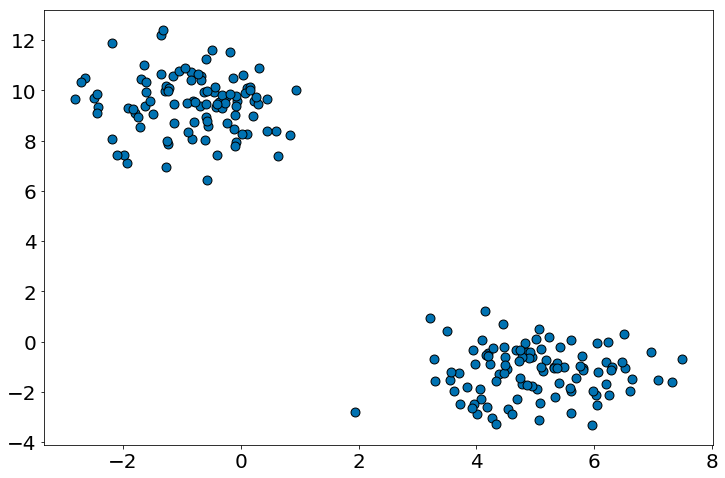

In [34]:
plt.scatter(X.asnumpy()[:, 0], X.asnumpy()[:, 1], s=80, edgecolors='k')

13. Assim como foi feito na primeira aula, abaixo testamos o seu código com um toy dataset.

In [35]:
# Use essa função antes de executar o GD
def add_intercept(X):
    Xn = nd.zeros(shape=(X.shape[0], X.shape[1] + 1))
    Xn[:, 0]  = 1
    Xn[:, 1:] = X
    return Xn

In [36]:
Xn = add_intercept(X)
theta = minibatch_gd(derivada_mxnet_logit, cross_entropy_mean, Xn, y)

Iter 0; theta =  
[ 0.5419693   0.18026772  0.34757292]
<NDArray 3 @cpu(0)>
Iter 1; theta =  
[ 0.53842765  0.16258252  0.35234648]
<NDArray 3 @cpu(0)>
Iter 2; theta =  
[ 0.53477329  0.1435411   0.35686898]
<NDArray 3 @cpu(0)>
Iter 3; theta =  
[ 0.53180611  0.12768504  0.36209968]
<NDArray 3 @cpu(0)>
Iter 4; theta =  
[ 0.52849287  0.11063049  0.36579585]
<NDArray 3 @cpu(0)>
Iter 5; theta =  
[ 0.52533108  0.09352569  0.3702186 ]
<NDArray 3 @cpu(0)>
Iter 6; theta =  
[ 0.5222339   0.07682439  0.37528068]
<NDArray 3 @cpu(0)>
Iter 7; theta =  
[ 0.51899272  0.06021415  0.37938088]
<NDArray 3 @cpu(0)>
Iter 8; theta =  
[ 0.5165115   0.04797362  0.38283768]
<NDArray 3 @cpu(0)>
Iter 9; theta =  
[ 0.51388389  0.03443763  0.38611808]
<NDArray 3 @cpu(0)>
Iter 10; theta =  
[ 0.51153469  0.0218704   0.38880655]
<NDArray 3 @cpu(0)>
Iter 11; theta =  
[ 0.50875628  0.00755084  0.39287522]
<NDArray 3 @cpu(0)>
Iter 12; theta =  
[ 0.50609028 -0.00610288  0.39666116]
<NDArray 3 @cpu(0)>
Iter 13; 

Iter 138; theta =  
[ 0.40403134 -0.51758647  0.52750111]
<NDArray 3 @cpu(0)>
Iter 139; theta =  
[ 0.40358013 -0.51965493  0.52797914]
<NDArray 3 @cpu(0)>
Iter 140; theta =  
[ 0.40335205 -0.52085429  0.52837127]
<NDArray 3 @cpu(0)>
Iter 141; theta =  
[ 0.40301129 -0.52261853  0.52879846]
<NDArray 3 @cpu(0)>
Iter 142; theta =  
[ 0.40258056 -0.52465594  0.52910495]
<NDArray 3 @cpu(0)>
Iter 143; theta =  
[ 0.40227723 -0.52616686  0.5295592 ]
<NDArray 3 @cpu(0)>
Iter 144; theta =  
[ 0.40197772 -0.52772266  0.5299136 ]
<NDArray 3 @cpu(0)>
Iter 145; theta =  
[ 0.40163246 -0.52931511  0.53043181]
<NDArray 3 @cpu(0)>
Iter 146; theta =  
[ 0.40135473 -0.53065348  0.53090757]
<NDArray 3 @cpu(0)>
Iter 147; theta =  
[ 0.40115118 -0.53178966  0.53129965]
<NDArray 3 @cpu(0)>
Iter 148; theta =  
[ 0.40084955 -0.53322411  0.53173989]
<NDArray 3 @cpu(0)>
Iter 149; theta =  
[ 0.40055373 -0.53472656  0.53215086]
<NDArray 3 @cpu(0)>
Iter 150; theta =  
[ 0.40028292 -0.53602117  0.53265047]
<NDArr

Iter 271; theta =  
[ 0.37352467 -0.66513759  0.56901944]
<NDArray 3 @cpu(0)>
Iter 272; theta =  
[ 0.37335816 -0.66593909  0.56926918]
<NDArray 3 @cpu(0)>
Iter 273; theta =  
[ 0.37322193 -0.66659194  0.56956947]
<NDArray 3 @cpu(0)>
Iter 274; theta =  
[ 0.37305549 -0.66738105  0.56988591]
<NDArray 3 @cpu(0)>
Iter 275; theta =  
[ 0.37292904 -0.66802347  0.57011658]
<NDArray 3 @cpu(0)>
Iter 276; theta =  
[ 0.37275288 -0.66883916  0.57042903]
<NDArray 3 @cpu(0)>
Iter 277; theta =  
[ 0.37256131 -0.66970897  0.57055473]
<NDArray 3 @cpu(0)>
Iter 278; theta =  
[ 0.37241498 -0.67042732  0.57077122]
<NDArray 3 @cpu(0)>
Iter 279; theta =  
[ 0.37223247 -0.67124319  0.57098126]
<NDArray 3 @cpu(0)>
Iter 280; theta =  
[ 0.37204838 -0.67211574  0.57118291]
<NDArray 3 @cpu(0)>
Iter 281; theta =  
[ 0.37189803 -0.67277473  0.57142866]
<NDArray 3 @cpu(0)>
Iter 282; theta =  
[ 0.37175453 -0.67351371  0.5716427 ]
<NDArray 3 @cpu(0)>
Iter 283; theta =  
[ 0.37160185 -0.674236    0.5719443 ]
<NDArr

Iter 389; theta =  
[ 0.35766497 -0.74138606  0.59318167]
<NDArray 3 @cpu(0)>
Iter 390; theta =  
[ 0.35752961 -0.74199688  0.59338588]
<NDArray 3 @cpu(0)>
Iter 391; theta =  
[ 0.3573859  -0.74264109  0.5936603 ]
<NDArray 3 @cpu(0)>
Iter 392; theta =  
[ 0.35730973 -0.74301827  0.59387839]
<NDArray 3 @cpu(0)>
Iter 393; theta =  
[ 0.35717237 -0.74363208  0.59404337]
<NDArray 3 @cpu(0)>
Iter 394; theta =  
[ 0.35704616 -0.74424005  0.59423172]
<NDArray 3 @cpu(0)>
Iter 395; theta =  
[ 0.35694054 -0.74473     0.59432268]
<NDArray 3 @cpu(0)>
Iter 396; theta =  
[ 0.35684896 -0.74516988  0.59452307]
<NDArray 3 @cpu(0)>
Iter 397; theta =  
[ 0.35670596 -0.74585223  0.59462494]
<NDArray 3 @cpu(0)>
Iter 398; theta =  
[ 0.35664219 -0.74619389  0.59480953]
<NDArray 3 @cpu(0)>
Iter 399; theta =  
[ 0.35650069 -0.74682301  0.59492606]
<NDArray 3 @cpu(0)>
Iter 400; theta =  
[ 0.35633224 -0.74751347  0.59511459]
<NDArray 3 @cpu(0)>
Iter 401; theta =  
[ 0.35628653 -0.74781072  0.59532624]
<NDArr

Iter 528; theta =  
[ 0.34414083 -0.8057847   0.61376941]
<NDArray 3 @cpu(0)>
Iter 529; theta =  
[ 0.34400249 -0.80637872  0.61386973]
<NDArray 3 @cpu(0)>
Iter 530; theta =  
[ 0.34390143 -0.80681062  0.61396706]
<NDArray 3 @cpu(0)>
Iter 531; theta =  
[ 0.34386101 -0.80703038  0.61409837]
<NDArray 3 @cpu(0)>
Iter 532; theta =  
[ 0.34378305 -0.80738211  0.6141842 ]
<NDArray 3 @cpu(0)>
Iter 533; theta =  
[ 0.34369224 -0.80782157  0.61432678]
<NDArray 3 @cpu(0)>
Iter 534; theta =  
[ 0.34358901 -0.80829012  0.61444956]
<NDArray 3 @cpu(0)>
Iter 535; theta =  
[ 0.34350216 -0.80871707  0.61459237]
<NDArray 3 @cpu(0)>
Iter 536; theta =  
[ 0.34343728 -0.80904752  0.61476624]
<NDArray 3 @cpu(0)>
Iter 537; theta =  
[ 0.34334436 -0.80948877  0.61491436]
<NDArray 3 @cpu(0)>
Iter 538; theta =  
[ 0.34325895 -0.80990607  0.6150583 ]
<NDArray 3 @cpu(0)>
Iter 539; theta =  
[ 0.3431195  -0.81047499  0.61515182]
<NDArray 3 @cpu(0)>
Iter 540; theta =  
[ 0.34303752 -0.81085247  0.61529994]
<NDArr

Iter 672; theta =  
[ 0.33338699 -0.85736012  0.63105261]
<NDArray 3 @cpu(0)>
Iter 673; theta =  
[ 0.33333278 -0.8576172   0.63117576]
<NDArray 3 @cpu(0)>
Iter 674; theta =  
[ 0.3333005  -0.85779268  0.63129252]
<NDArray 3 @cpu(0)>
Iter 675; theta =  
[ 0.33323693 -0.85810828  0.63143384]
<NDArray 3 @cpu(0)>
Iter 676; theta =  
[ 0.33317885 -0.85840005  0.63154685]
<NDArray 3 @cpu(0)>
Iter 677; theta =  
[ 0.33310625 -0.85874975  0.63165426]
<NDArray 3 @cpu(0)>
Iter 678; theta =  
[ 0.33306068 -0.8589856   0.63178104]
<NDArray 3 @cpu(0)>
Iter 679; theta =  
[ 0.33296639 -0.85939252  0.6318562 ]
<NDArray 3 @cpu(0)>
Iter 680; theta =  
[ 0.33286336 -0.85982764  0.63191402]
<NDArray 3 @cpu(0)>
Iter 681; theta =  
[ 0.33280578 -0.86010301  0.63201362]
<NDArray 3 @cpu(0)>
Iter 682; theta =  
[ 0.33278808 -0.86023223  0.63213193]
<NDArray 3 @cpu(0)>
Iter 683; theta =  
[ 0.33269408 -0.86062628  0.63218582]
<NDArray 3 @cpu(0)>
Iter 684; theta =  
[ 0.33263662 -0.86090958  0.63232499]
<NDArr

In [37]:
y_p = logistica_prever(Xn, theta)
print((y == y_p).mean())


[ 1.]
<NDArray 1 @cpu(0)>
